# Exploratory analysis of COVID-19 risk factors

# Introduction

Exploration of the [Covid-19 dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) for the task: [What do we know about COVID-19 risk factors?](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks?taskId=558).  

Social determinants of health will be explored for knowledge that might be derived from the literature dataset. Based on keywords taken from the task details, subsets of terms were used to extract document-term matrices relevant to each task.  Highly interesting results could be manually reviewed by an expert.

For example, for Task 1a, a list of terms related to ‘risk factors’ and another list of terms related to ‘smoking’ or ‘pre-existing pulmonary disease’ could be combined to create a 'query'.  To broaden each term set, additional synonyms were added each of the term sets by manual curation.

The relevant terms from the task details are shown below enclosed in brackets with superscripts that identify the number of the corresponding term set.

<b>Task Details</b>
1. Data on potential {risk factors}<sup>1</sup>
    <br>a. {Smoking, pre-existing pulmonary disease}<sup>2</sup>
    <br>b. {Co-infections}<sup>3</sup> (determine whether {co-existing respiratory/viral infections}<sup>3</sup> make the virus more {transmissible or virulent}<sup>4</sup>) and other {co-morbidities}<sup>3</sup>
    <br>c. {Neonates and pregnant}<sup>5</sup> women
    <br>d. {Socio-economic}<sup>6</sup> and {behavioral factors}<sup>6</sup> to understand the {economic}<sup>6</sup> impact of the virus and whether there were differences.
2. {Transmission dynamics}<sup>7</sup> of the virus, including the basic {reproductive number, incubation period, serial interval, modes of transmission and environmental factors}<sup>7</sup>
3. {Severity}<sup>8</sup> of disease, including risk of {fatality}<sup>8</sup> among {symptomatic hospitalized patients}<sup>9</sup>, and {high-risk patient}<sup>9</sup> groups
4. {Susceptibility}<sup>1</sup> of {populations}<sup>10</sup>
5. {Public health}<sup>11</sup> {mitigation}<sup>13</sup> {measures}<sup>12</sup> that could be effective for {control}<sup>13</sup>


## Term set composition

Using this method, the term sets that were constructed are shown below. The root terms taken from the task details are highlighted.
			
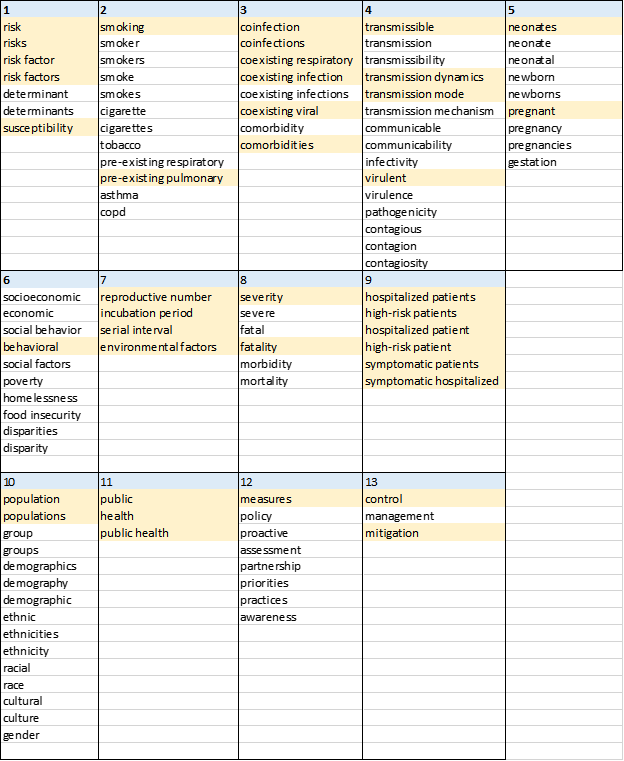


## Scoring documents for task relevance

<b>Computing term set relevance for each document:</b>
1. For each document, compute the document-length normalized term frequency for each term
2. For each document, compute the document's term set relevance (the maximimum score out of all the terms in the term set for a given document)
3. Min-Max normalize the document's term set relevance

<b>Combining the term sets to produce task relevance:</b>
<br>
<br>
To construct a ‘query’ from the task lists, the scored document-term set relevance tables were combined according to the the following matrix, where squares shown in green represent the term lists that were combined for each task. To produce an overall score for each document for each task, the document's term set relevances were multiplied together for all the term sets making up each task.

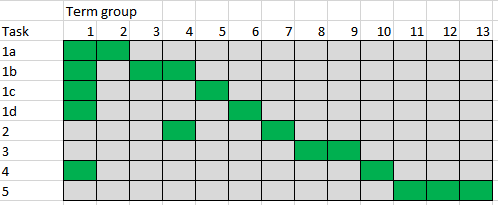

## Discussion of the pros/cons of this method

<b>Pros:</b>
<br>
* This method attempts to capture all parts of a task by assigning equal importance to different parts of the task.  For example, when determining Public health mitigation measures that could be effective for control (task 5), equal weights are assigned to three different requirements of the task by multiplying the three representative term sets together.  For example, to capture the linkage between Public health <--> measures <--> mitigation/control. It requires all three components of the relationship to be strongly represented by thier respective term sets. 
* It utilizes a straightforward bag of words approach (via the term document matrix) and does not require complex logic to identify relevant documetnts. 
<br>

<br>
<b>Cons:</b>
* While the method for determining document relatedness to a task is conceptually basic, it may miss subtleties in the thesis of the documents that would be better captured by an NLP methods, such as the order of cause and effect between relevant terms.  In the preceding example, the linkage between Public health <--> measures <--> for mitigation/control does not imply a cause and effect relationship such as Public health --> measures --> for mitigation/control.


## Acknowledgements

The author wishes to thank user [xhlulu](https://www.kaggle.com/xhlulu) for permission to reuse the dataset located at the kernal [here](https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv).

# 1. Load and clean the data

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
def load_from_csv(wkgdir):
    
    bio = pd.read_csv(wkgdir + './biorxiv_clean.csv')
    comm = pd.read_csv(wkgdir + './clean_comm_use.csv')
    noncomm = pd.read_csv(wkgdir + './clean_noncomm_use.csv')
    custom = pd.read_csv(wkgdir + './clean_pmc.csv')
    
    corpus = pd.concat([bio,comm,noncomm,custom], ignore_index=True)
    
    return corpus

In [3]:
corpus = load_from_csv('../input/cord-19-eda-parse-json-and-generate-clean-csv/')

In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40144 entries, 0 to 40143
Data columns (total 9 columns):
paper_id            40144 non-null object
title               35822 non-null object
authors             36083 non-null object
affiliations        36083 non-null object
abstract            29306 non-null object
text                40144 non-null object
bibliography        40144 non-null object
raw_authors         40144 non-null object
raw_bibliography    40144 non-null object
dtypes: object(9)
memory usage: 2.8+ MB


### Clean up the columns in the dataframe

In [5]:
# Replace missing data with NA
corpus = corpus.fillna('not available')

In [6]:
def clean(col):
    col = col.replace('\n', '')
    col = col.replace('\r', '')    
    col = col.replace('\t', '')
    col = re.sub("\[[0-9]+(,[0-9]+)*\]", "", col)
    col = re.sub("\([0-9]+(,[0-9]+)*\)", "", col)
    col = re.sub("\{[0-9]+(,[0-9]+)*\}", "", col)

    return col
    
corpus['abstract'] = corpus['abstract'].apply(clean)
corpus['text'] = corpus['text'].apply(clean)

### Combine the title, abstract, and body text into a new column

In [7]:
corpus.rename(columns={'text':'body_text'}, inplace=True)
corpus['text'] = corpus.title + ' ' + corpus.abstract + ' ' + corpus.body_text 

In [8]:
# Drop astract and body text columns
corpus = corpus.drop(['body_text', 'abstract'], axis=1)

# 2. Creating a document term matrix for each term set

### Create document term matrices for lists of terms that are relevant to each of the tasks

In [9]:
# Target term lists
s1 = ['risk', 'risks', 'risk factor', 'risk factors', 'determinant', 'determinants','susceptibility']
s2 = ['smoking', 'smoker', 'smokers', 'smoke', 'smokes', 'cigarette', 'cigarettes', 'tobacco', 'pre-existing respiratory', 'pre-existing pulmonary', 'asthma', 'copd']
s3 = ['coinfection', 'coinfections', 'coexisting respiratory', 'coexisting infection', 'coexisting infections', 'coexisting viral', 'comorbidity', 'comorbidities']
s4 = ['transmissible', 'transmission', 'transmissibility', 'communicable', 'communicability', 'infectivity', 'virulent', 'virulence', 'pathogenicity','contagious','contagion','contagiosity']
s5 = ['neonates', 'neonate', 'newborn', 'newborns', 'pregnant', 'pregnancy', 'pregnancies', 'gestation']
s6 = ['socio-economic', 'socioeconomic', 'economic', 'social behavior', 'behavioral', 'social factors', 'poverty','homelessness','food insecurity','disparity','disparities']
s7 = ['reproductive number', 'incubation period', 'serial interval', 'environmental factors']
s8 = ['severity', 'severe', 'fatal', 'fatality', 'morbidity', 'mortality']
s9 = ['high-risk patients', 'hospitalized patient', 'high-risk patient', 'symptomatic patients', 'symptomatic hospitalized']
s10 = ['population', 'populations', 'group', 'groups', 'demographics', 'demography', 'demographic', 'ethnic', 'ethnicities', 'ethnicity', 'racial', 'race', 'cultural', 'culture', 'gender']
s11 = ['public', 'health', 'public health']
s12 = ['measures', 'policy', 'proactive', 'assessment', 'partnership', 'priorities', 'practices', 'awareness']
s13 = ['control', 'management', 'mitigation']

In [10]:
# CountVectorizer with select vocabulary

def vocab_vectorizer(feature, vocab):

    '''
    Generates: document term matrix using a select vocabulary
    Args: 
        feature - dataframe column containing text to vectorize
        vocab - the specific list of terms from which to generate the matrix
    Returns: document term matrix as a dataframe 
    '''

    # generate a document term matrix
    CV1 = CountVectorizer(input="content", ngram_range=(1,2), vocabulary = vocab)
    DTM1 = CV1.fit_transform(corpus[feature])

    # add col names
    ColNames=CV1.get_feature_names()

    DF1 = pd.DataFrame(DTM1.toarray(), columns=ColNames)

    # add row names
    Dict1 = {}
    for i in range(0, len(corpus.paper_id)):
        Dict1[i] = corpus.paper_id[i]
    DF1 = DF1.rename(Dict1, axis='index')

    return DF1

### Loop through the term sets to get a document-term matrix for each.

In [11]:
term_sets = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13] 
dtm_sets = []

for s in tqdm(term_sets):
    dtm_sets.append(vocab_vectorizer(feature='text', vocab=s))

### Generate raw word counts for each document that can be used to normalize term frequencies by document length

In [12]:
def word_count (field):
    
    tokens = field.split()
    field_length = len(tokens)
    
    return field_length

In [13]:
doc_lengths = pd.DataFrame( {'word_count' : corpus['text'].apply(word_count)} )

### Normalize the vectors by dividing by the document length

In [14]:
def length_normalize(dtm, doc_lengths):
    
    # Replace missing data with NA
    #dtm = dtm.fillna(0)
    
    for i in range(dtm.shape[1]):
    # Select column by index position using iloc[]
        columnSeriesObj = dtm.iloc[: , i]
        columnSeriesObj2 = columnSeriesObj / doc_lengths.word_count.values
        dtm.iloc[: , i] = columnSeriesObj2

    return dtm


dtm_sets_norm = []

for s in dtm_sets:
    dtm_sets_norm.append(length_normalize(s,doc_lengths))

In [15]:
dtm_sets_norm = []

for s in dtm_sets:
    dtm_sets_norm.append(length_normalize(s,doc_lengths))

### Calculate the maximum feature value for every document for each term set, then min-max normalize the values of the maximum value feature.

In [16]:
def max_set_features(s):
    
    s['max'] = s.max(axis=1)
    
    max_array = np.array(s['max']).reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    
    s['min_max'] = min_max_scaler.fit_transform(max_array)
    
    return s


In [17]:
dtm_sets_max = []

for s in dtm_sets_norm:
    dtm_sets_max.append(max_set_features(s))

### Assemble the results into one data frame

In [18]:
dtm_dict = { 'paper_id' : corpus['paper_id']
            , 'dtm1' : dtm_sets_max[0]['min_max'].values
            ,'dtm2' : dtm_sets_max[1]['min_max'].values
            ,'dtm3' : dtm_sets_max[2]['min_max'].values
            ,'dtm4' : dtm_sets_max[3]['min_max'].values
            ,'dtm5' : dtm_sets_max[4]['min_max'].values
            ,'dtm6' : dtm_sets_max[5]['min_max'].values
            ,'dtm7' : dtm_sets_max[6]['min_max'].values
            ,'dtm8' : dtm_sets_max[7]['min_max'].values
            ,'dtm9' : dtm_sets_max[8]['min_max'].values
            ,'dtm10' : dtm_sets_max[9]['min_max'].values
            ,'dtm11' : dtm_sets_max[10]['min_max'].values
            ,'dtm12' : dtm_sets_max[11]['min_max'].values
            ,'dtm13' : dtm_sets_max[12]['min_max'].values
           }

dtm_columns=['paper_id', 'dtm1', 'dtm2','dtm3','dtm4', 'dtm5', 'dtm6','dtm7', 'dtm8','dtm9','dtm10', 'dtm11', 'dtm12','dtm13']

dtm_summary = pd.DataFrame(dtm_dict,columns=dtm_columns)

del dtm_dict, dtm_columns

# 3. Combining document-Term set scores to produce task relevance scores

### For each task, calculate the score by multiplying the normalized max scores for each set together to generate a composite score representing how strongly each document reflects each task.

In [19]:
task1a = pd.DataFrame({ 'paper_id' : corpus['paper_id'], 'score' : dtm_summary['dtm1'] * dtm_summary['dtm2']}
                      , columns=['paper_id','score'])

task1b = pd.DataFrame({ 'paper_id' : corpus['paper_id'], 'score' : dtm_summary['dtm1'] * dtm_summary['dtm3'] * dtm_summary['dtm4']}
                      , columns=['paper_id','score'])

task1c = pd.DataFrame({ 'paper_id' : corpus['paper_id'], 'score' : dtm_summary['dtm1'] * dtm_summary['dtm5']}
                      , columns=['paper_id','score'])

task1d = pd.DataFrame({ 'paper_id' : corpus['paper_id'], 'score' : dtm_summary['dtm1'] * dtm_summary['dtm6']}
                      , columns=['paper_id','score'])

task2 = pd.DataFrame({ 'paper_id' : corpus['paper_id'], 'score' : dtm_summary['dtm4'] * dtm_summary['dtm7']}
                      , columns=['paper_id','score'])

task3 = pd.DataFrame({ 'paper_id' : corpus['paper_id'], 'score' : dtm_summary['dtm8'] * dtm_summary['dtm9']}
                      , columns=['paper_id','score'])

task4 = pd.DataFrame({ 'paper_id' : corpus['paper_id'], 'score' : dtm_summary['dtm1'] * dtm_summary['dtm10']}
                      , columns=['paper_id','score'])

task5 = pd.DataFrame({ 'paper_id' : corpus['paper_id'], 'score' : dtm_summary['dtm11'] * dtm_summary['dtm12'] * dtm_summary['dtm13']}
                      , columns=['paper_id','score'])

### Sort the dataframes, take the top 100 results from each task, and get the text for those documents

In [20]:
task1a = task1a.sort_values(by='score',ascending=False)
task1b = task1b.sort_values(by='score',ascending=False)
task1c = task1c.sort_values(by='score',ascending=False)
task1d = task1d.sort_values(by='score',ascending=False)
task2 = task2.sort_values(by='score',ascending=False)
task3 = task3.sort_values(by='score',ascending=False)
task4 = task4.sort_values(by='score',ascending=False)
task5 = task5.sort_values(by='score',ascending=False)

In [21]:
task1a.head()

,paper_id,score
27355,a946582580b10f59b7267ae8e6e312a08fe90552,0.001736
26689,ef6fe3fbcb779579ce62f9c4f3befa321be66113,0.001512
33225,34ba72963a44bbe5ce71b7ec96c6f71dd1069c2e,0.001232
19005,1c406ea14d2e344812f28f1c17cc8bcace7fda3f,0.001232
11355,dc3717164035118202545e92237895cb7f74f18c,0.001196


In [22]:
task1a_top100 = task1a.iloc[:100,:]
task1b_top100 = task1b.iloc[:100,:]
task1c_top100 = task1c.iloc[:100,:]
task1d_top100 = task1d.iloc[:100,:]
task2_top100 = task2.iloc[:100,:]
task3_top100 = task3.iloc[:100,:]
task4_top100 = task4.iloc[:100,:]
task5_top100 = task5.iloc[:100,:]

In [23]:
task1a_top100 = task1a_top100.merge(corpus, how='left', on='paper_id', sort=False )
task1b_top100 = task1b_top100.merge(corpus, how='left', on='paper_id', sort=False )
task1c_top100 = task1c_top100.merge(corpus, how='left', on='paper_id', sort=False )
task1d_top100 = task1d_top100.merge(corpus, how='left', on='paper_id', sort=False )
task2_top100 = task2_top100.merge(corpus, how='left', on='paper_id', sort=False )
task3_top100 = task3_top100.merge(corpus, how='left', on='paper_id', sort=False )
task4_top100 = task4_top100.merge(corpus, how='left', on='paper_id', sort=False )
task5_top100 = task5_top100.merge(corpus, how='left', on='paper_id', sort=False )

In [24]:
task1a_top100.head()

,paper_id,score,title,authors,affiliations,bibliography,raw_authors,raw_bibliography,text
0,a946582580b10f59b7267ae8e6e312a08fe90552,0.001736,not available,Hua Cai,"Hua Cai (University of California Los Angeles,...","Single-cell RNA expression profiling of ACE2, ...","[{'first': 'Hua', 'middle': [], 'last': 'Cai',...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Single-...","not available not available , so that might al..."
1,ef6fe3fbcb779579ce62f9c4f3befa321be66113,0.001512,not available,not available,not available,China critical care clinical trials group (CCC...,[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'China c...","not available not available To the Editor,Coro..."
2,34ba72963a44bbe5ce71b7ec96c6f71dd1069c2e,0.001232,574 Coronavirus NL63 Illnesses in Infancy are ...,"T E Pappas, K T Sullivan Dille, W Lee, K A Gri...",T E Pappas (University of Wisconsin Population...,RATIONALE: Asthma is a heritable trait charact...,"[{'first': 'T', 'middle': ['E'], 'last': 'Papp...","{'BIBREF0': {'ref_id': 'b0', 'title': 'RATIONA...",574 Coronavirus NL63 Illnesses in Infancy are ...
3,1c406ea14d2e344812f28f1c17cc8bcace7fda3f,0.001232,574 Coronavirus NL63 Illnesses in Infancy are ...,"T E Pappas, K T Sullivan Dille, W Lee, K A Gri...",T E Pappas (University of Wisconsin Population...,RATIONALE: Asthma is a heritable trait charact...,"[{'first': 'T', 'middle': ['E'], 'last': 'Papp...","{'BIBREF0': {'ref_id': 'b0', 'title': 'RATIONA...",574 Coronavirus NL63 Illnesses in Infancy are ...
4,dc3717164035118202545e92237895cb7f74f18c,0.001196,More awareness is needed for severe acute resp...,not available,not available,World Health Organization. Novel Coronavirus (...,[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'World H...",More awareness is needed for severe acute resp...


In [25]:
#eliminate any remaining numbers from text
task1a_top100['text'] = task1a_top100['text'].replace('\d+', 'NUM', regex=True)
task1b_top100['text'] = task1b_top100['text'].replace('\d+', 'NUM', regex=True)
task1c_top100['text'] = task1c_top100['text'].replace('\d+', 'NUM', regex=True)
task1d_top100['text'] = task1d_top100['text'].replace('\d+', 'NUM', regex=True)
task2_top100['text'] = task2_top100['text'].replace('\d+', 'NUM', regex=True)
task3_top100['text'] = task3_top100['text'].replace('\d+', 'NUM', regex=True)
task4_top100['text'] = task4_top100['text'].replace('\d+', 'NUM', regex=True)
task5_top100['text'] = task5_top100['text'].replace('\d+', 'NUM', regex=True)

# 4. Generate TFIDF-weighted document-term matrices for each task

### Here, for the top 100 most highly ranked documents for each task, generate feature vectors containing the top 100 TF-IDF-weighted features

In [26]:
# TfidfVectorizer with select vocabulary

def tfidf_vectorizer(df):

    '''
    Generates: tfidf document term matrix
    Args: dataframe
    Returns: document term matrix as a dataframe 
    '''

    
    # generate a document term matrix
    CV1 = TfidfVectorizer(input="content", ngram_range=(1,2), stop_words = 'english',  max_df=0.3, max_features=100)
    DTM1 = CV1.fit_transform(df['text'])

    # add col names
    ColNames=CV1.get_feature_names()

    DF1 = pd.DataFrame(DTM1.toarray(), columns=ColNames)

    # add row names
    Dict1 = {}
    for i in range(0, len(df.paper_id)):
        Dict1[i] = df.paper_id[i]
    DF1 = DF1.rename(Dict1, axis='index')

    return DF1
    

In [27]:
task1a_top100_tfidf = tfidf_vectorizer(task1a_top100)
task1b_top100_tfidf = tfidf_vectorizer(task1b_top100)
task1c_top100_tfidf = tfidf_vectorizer(task1c_top100)
task1d_top100_tfidf = tfidf_vectorizer(task1d_top100)
task2_top100_tfidf = tfidf_vectorizer(task1d_top100)
task3_top100_tfidf = tfidf_vectorizer(task1d_top100)
task4_top100_tfidf = tfidf_vectorizer(task1d_top100)
task5_top100_tfidf = tfidf_vectorizer(task1d_top100)

In [28]:
task1a_top100_tfidf.head()

,adjusted,aged,al num,allergic,allergic sensitization,allergy,analyses,antiviral,asthma control,asthma development,...,vaccine,viral respiratory,virus induced,visit,visits,vitamin,vs,wheeze,wheezing illnesses,women
a946582580b10f59b7267ae8e6e312a08fe90552,0.0,0.052226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.113055,0.0,0.000000,0.315007
ef6fe3fbcb779579ce62f9c4f3befa321be66113,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
34ba72963a44bbe5ce71b7ec96c6f71dd1069c2e,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065723,...,0.0,0.0,0.0,0.0,0.111886,0.0,0.346795,0.0,0.063182,0.000000
1c406ea14d2e344812f28f1c17cc8bcace7fda3f,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065723,...,0.0,0.0,0.0,0.0,0.111886,0.0,0.346795,0.0,0.063182,0.000000
dc3717164035118202545e92237895cb7f74f18c,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [29]:
task1b_top100_tfidf.head()

,acquired,admission,aged,al,al num,bacterial,camel,camels,care workers,cases reported,...,tract,travel,tuberculosis,understanding,united,vaccination,vaccine,variables,ventilation,wuhan
fd2bb1fa5b9df8b5223cb493a6d9a317c749f89b,0.0,0.000000,0.424457,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000
9b42cd1e0351904948f63632cf9c1a0152ffebb6,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.17608,0.156809
6f3c633b7fd7f6d02ed987224eb8001b9e740919,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.499617,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.499617
c4243eccc82c5b1f6a7cfe910e2167556feab414,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.134141,0.000000,0.0,...,0.000000,0.000000,0.0,0.389769,0.000000,0.0,0.0,0.0,0.00000,0.000000
21a601344a7d90862aa4a0495bdc6e88973dc81e,0.0,0.062642,0.000000,0.0,0.0,0.0,0.0,0.000000,0.250568,0.0,...,0.061697,0.250568,0.0,0.000000,0.064633,0.0,0.0,0.0,0.00000,0.000000


# 5.  Visualize top 100 documents for each task as kmeans clusters

### k-means clustering may be able to help identify subsets of related documents within the 100 most task-relevant documents for each task.

### Begin by looking at a principle components analysis of the top 11 documents for some tasks

In [30]:
def tfidf_pca(df):
    
    pca = PCA(n_components=2).fit(df)
    pca_2d = pca.transform(df)

    for i in range(0, pca_2d.shape[0]):

        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',
            marker='+')
        
    return c1

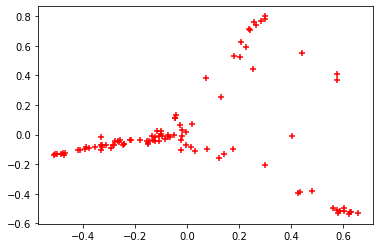

In [31]:
task1a_tfidf_pca = tfidf_pca(task1a_top100_tfidf)

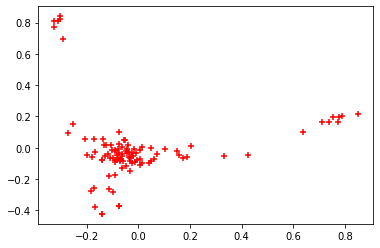

In [32]:
task1b_tfidf_pca = tfidf_pca(task1b_top100_tfidf)

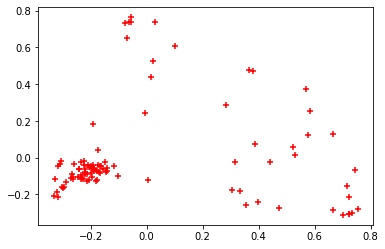

In [33]:
task1c_tfidf_pca = tfidf_pca(task1c_top100_tfidf)

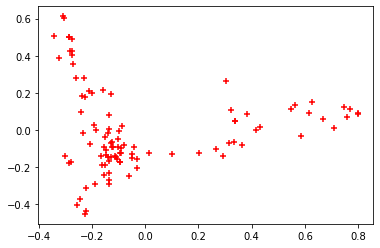

In [34]:
task1d_tfidf_pca = tfidf_pca(task1d_top100_tfidf)

In [35]:
def tfidf_pca_kmeans(df,num_clusters):
    
    pca = PCA(n_components=2).fit(df)
    pca_2d = pca.transform(df)

    task_tfidf_kmeans = KMeans(n_clusters=num_clusters, random_state=111)
    task_tfidf_kmeans.fit(df)

    c1 = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=task_tfidf_kmeans.labels_)

    return c1, task_tfidf_kmeans

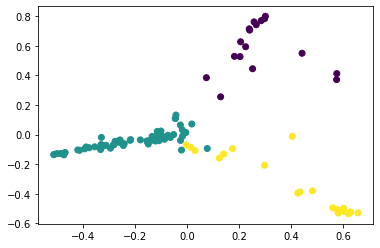

In [36]:
task1a_tfidf_plot, task1a_tfidf_pca_kmeans = tfidf_pca_kmeans(task1a_top100_tfidf, num_clusters=3)

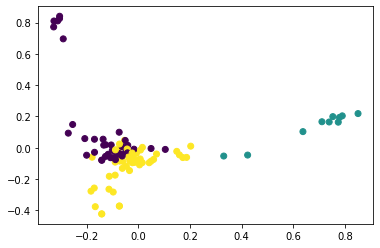

In [37]:
task1b_tfidf_plot, task1b_tfidf_pca_kmeans = tfidf_pca_kmeans(task1b_top100_tfidf, num_clusters=3)

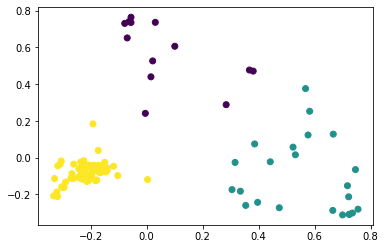

In [38]:
task1c_tfidf_plot, task1c_tfidf_pca_kmeans = tfidf_pca_kmeans(task1c_top100_tfidf, num_clusters=3)

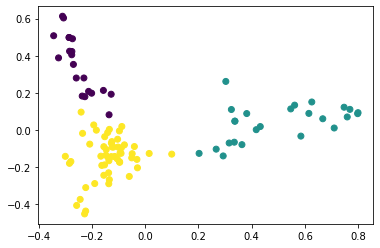

In [39]:
task1d_tfidf_plot, task1d_tfidf_pca_kmeans = tfidf_pca_kmeans(task1d_top100_tfidf, num_clusters=3)

### Based on the above PCA analysis, it looks like three k-means clusters should be about right

### Get the k-means cluster identifications for the top 100 ranked documents for all of the tasks

In [40]:
def tfidf_kmeans(df,num_clusters):

    task_tfidf_kmeans = KMeans(n_clusters=num_clusters, random_state=111)
    task_tfidf_kmeans.fit(df)
    
    task_tfidf_kmeans_labels = task_tfidf_kmeans.labels_
    task_tfidf_kmeans_df = pd.DataFrame([df.index,task_tfidf_kmeans_labels]).T
    
    task_tfidf_kmeans_df.columns = ['paper_id', 'cluster']

    return task_tfidf_kmeans_df

In [41]:
task1a_tfidf_pca_kmeans_df = tfidf_kmeans(task1a_top100_tfidf,3)
task1b_tfidf_pca_kmeans_df = tfidf_kmeans(task1b_top100_tfidf,3)
task1c_tfidf_pca_kmeans_df = tfidf_kmeans(task1c_top100_tfidf,3)
task1d_tfidf_pca_kmeans_df = tfidf_kmeans(task1d_top100_tfidf,3)
task2_tfidf_pca_kmeans_df = tfidf_kmeans(task2_top100_tfidf,3)
task3_tfidf_pca_kmeans_df = tfidf_kmeans(task3_top100_tfidf,3)
task4_tfidf_pca_kmeans_df = tfidf_kmeans(task4_top100_tfidf,3)
task5_tfidf_pca_kmeans_df = tfidf_kmeans(task5_top100_tfidf,3)

### Look at some of the documents in a cluster

In [42]:
task1a_tfidf_pca_kmeans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
paper_id    100 non-null object
cluster     100 non-null object
dtypes: object(2)
memory usage: 1.7+ KB


In [43]:
task1a_tfidf_cluster1 = task1a_tfidf_pca_kmeans_df.loc[task1a_tfidf_pca_kmeans_df['cluster']==0]

In [44]:
task1a_tfidf_cluster1[:10]

,paper_id,cluster
0,a946582580b10f59b7267ae8e6e312a08fe90552,0
1,ef6fe3fbcb779579ce62f9c4f3befa321be66113,0
4,dc3717164035118202545e92237895cb7f74f18c,0
5,f4bde74efeb547d3d6d3f935482a80c9d456198f,0
6,16bfa83d011a2f290843d20f6850d8ea08a853ae,0
8,7ea01c3a765231b5e95a80c06a6f97afd7593a76,0
17,8b6b3527c51d85812d30c699cf39fdf480fa7def,0
19,73ab5445476f26b4dae4e6979a077d3c67edc5f7,0
24,25faa9b33c145b3074f67063527cffe961196ee1,0
25,2508ae945cb1111c9bfe068c7c7637fc31d71df6,0


# 6. Output information for the top 100 ranked documents for each task

### Join together all task-related document information

In [45]:
def prepare_output(task_df, task_tfidf_df, task_pca_kmeans_df):
    
    task_tfidf_df.reset_index(inplace=True)
    task_tfidf_df.rename(columns={'index':'paper_id'}, inplace=True)
    
    task_df = task_df.merge(task_pca_kmeans_df, how='left', on='paper_id', sort=False )
    task_df = task_df.merge(task_tfidf_df, how='left', on='paper_id', sort=False )
    
    return task_df

In [46]:
task1a_top100 = prepare_output(task1a_top100, task1a_top100_tfidf, task1a_tfidf_pca_kmeans_df)
#task1b_top100 = prepare_output(task1b_top100, task1b_top100_tfidf, task1b_tfidf_pca_kmeans_df)
task1c_top100 = prepare_output(task1c_top100, task1c_top100_tfidf, task1c_tfidf_pca_kmeans_df)
task1d_top100 = prepare_output(task1d_top100, task1d_top100_tfidf, task1d_tfidf_pca_kmeans_df)
task2_top100 = prepare_output(task2_top100, task2_top100_tfidf, task2_tfidf_pca_kmeans_df)
task3_top100 = prepare_output(task3_top100, task3_top100_tfidf, task3_tfidf_pca_kmeans_df)
task4_top100 = prepare_output(task4_top100, task4_top100_tfidf, task4_tfidf_pca_kmeans_df)
task5_top100 = prepare_output(task5_top100, task5_top100_tfidf, task5_tfidf_pca_kmeans_df)

task1a_top100.to_csv('task1a_top100.csv', sep=',')
#task1b_top100.to_csv('task1b_top100.csv', sep=',')
task1c_top100.to_csv('task1c_top100.csv', sep=',')
task1d_top100.to_csv('task1d_top100.csv', sep=',')
task2_top100.to_csv('task2_top100.csv', sep=',')
task3_top100.to_csv('task3_top100.csv', sep=',')
task4_top100.to_csv('task4_top100.csv', sep=',')
task5_top100.to_csv('task5_top100.csv', sep=',')

In [47]:
# task1b is run separately from the others because index column has different name
task1b_top100_tfidf.reset_index(inplace=True)
task1b_top100_tfidf.rename(columns={'level_0':'paper_id'}, inplace=True)
task1b_top100 = task1b_top100.merge(task1b_tfidf_pca_kmeans_df, how='left', on='paper_id', sort=False )
task1b_top100 = task1b_top100.merge(task1b_top100_tfidf, how='left', on='paper_id', sort=False )
task1b_top100.to_csv('task1b_top100.csv', sep=',')